In [ ]:
# Upgrade Oracle ADS to pick up latest features and maintain compatibility with Oracle Cloud Infrastructure.

!pip install -U oracle-ads

Oracle Data Science service sample notebook.

Copyright (c) 2020, 2022 Oracle, Inc. All rights reserved. Licensed under the [Universal Permissive License v 1.0](https://oss.oracle.com/licenses/upl).

---

# <font color="red">API Keys</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color="teal">Oracle Cloud Infrastructure Data Science Service.</font></p>

---
# Overview:

The notebook session user is `datascience` and this user has no Oracle Cloud Infrastructure (OCI) Identity and Access Management (IAM) identity. Therefore, it cannot access OCI resources outside of the notebook. However, OCI provides two methods for making authenticated API calls to access OCI resources. They are Resource Principles and API (public and private) keys. This notebook demonstrates how to generate API keys.

Compatible conda pack: [General Machine Learning](https://docs.oracle.com/en-us/iaas/data-science/using/conda-gml-fam.htm) for CPU on Python 3.8 (version 1.0)

---

## Contents: 

- <a href='#authentication'>Understanding Authentication to Oracle Cloud Infrastructure Resources from a Notebook Session</a>
- <a href='#config-key'>Authenticating Using API Keys</a>
     - <a href='#sec-con'>Security Considerations</a>
- <a href='#set-keys'>Setting Up the Configuration File and API Keys</a>
     - <a href='#copy-config'>Copying Configuration Settings</a>
     - <a href='#create-keys'>Creating the Configuration File and API Keys</a>
- <a href='#attach'>Attaching Public Key to User Account</a>
- <a href='#access-test'>Testing Access to the API</a>
- <a href='#method'>Setting Authentication Method in ADS</a>
- <a href='#ref'>References</a>     

---


Datasets are provided as a convenience.  Datasets are considered third-party content and are not considered materials 
under your agreement with Oracle.

---

In [ ]:
import logging
import os
import re
import subprocess
import warnings

from oci.config import from_file
from oci.exceptions import ServiceError
from oci.data_science import DataScienceClient
from os import path

warnings.filterwarnings("ignore")
logging.basicConfig(format="%(levelname)s:%(message)s", level=logging.ERROR)

<a id='authentication'></a>
# Understanding Authentication to Oracle Cloud Infrastructure Resources from a Notebook Session.

To access OCI resources, including Data Science projects or models from the notebook environment, you must use a configuration file and API keys or resource principles. This applies to the resources of any other OCI service including Object Storage, Functions, Vault, Data Flow, and so on.

Resource principles are not covered in this notebook so use the Getting Started notebook to learn about Resource Principles.

This notebook demonstrates how to configure the notebook session to use API keys. It creates the required configuration file and API keys. Then one of the API keys is attached to an OCI account. In the final step, you test to confirm that access is successful.

<a id='config-key'></a>
# Authenticating Using API Keys

The API key approach requires a configuration file, `config`, and a pair of encryption keys. The terms API keys and encryption keys are used interchangably. 

There is a public encryption key that is normally stored in the file `oci_api_key_public.pem` and the private key is in `oci_api_key.pem`. The configuration file identifies you to IAM. The encryption keys are used to authenticate that the user matches who is identified. The private key is stored in the block storage of the notebook session. The public key must be attached to an account. This notebook provides instructions to implement this configuration.

This notebook sets up a default configuration file. However, if it needs to be customized, see the [SDK and CLI Configuration File](https://docs.cloud.oracle.com/iaas/Content/API/Concepts/sdkconfig.htm).

<a id='sec-con'></a>
## Security Considerations

Once the public encryption key has been attached to your OCI account, anyone with access to the private key can access the resources that the account has access to. The private key must be available on the notebook session's Block Storage whenever the notebook session needs to access other OCI resources. Other users that have access to the notebook session have access to the private key. Therefore, it is important that the best security practices are followed to prevent the private key from being accessed by unauthorized users.

<a id='set-keys'></a>
# Setting Up the Configuration File and API Keys

If you have already set up a notebook session to access OCI resources, it is possible to copy the required files from one notebook to another as explained in [Copying Configuration Settings](#copy-config). If this is the first time setting up API access or a new set of keys need to be created, go to [Creating the Configuration File and API Keys](#create-keys).

<a id='copy-config'></a>
## Copying Configuration Settings

If there is an existing notebook session that has a configuration file and private key, you can copy these files from one notebook session to another. By default, the files are stored in the `~/.oci` folder.

<a id='create-keys'></a>
## Creating the Configuration File and API Keys

The first step in the process is to determine if your account is federated on non-federated. By default, the notebook session has a user OCID stored as the `USER_OCID`environment variable in the notebook session. To access resources from the notebook session, a **native** OCI user OCID is required. If the account is federated, then the user OCID in the environment variable `USER_OCID` is a native user OCID. If the account is non-federated, then the native user OCID has to be entered into this notebook.

Run the next cell to determine if your account is federated or non-federated, then follow the instructions in the output to determine the next step.

In [ ]:
user_ocid_pattern = "^ocid[0-9]?\.user.*"
federated_msg = """
This is a federated account, thus you must explicitly add the user OCID by following these steps:
1. Obtain the user OCID
    1. Open the Console, and sign in.
    2. Open the Profile menu (User menu icon).
    3. Click User Settings. The Identity -> Users -> User Details screen will appear.
    4. In the User Information section, there is an OCID line. Click Copy.
2. Update notebook
    1. Locate the line that looks like:
        user_ocid = '<USER_OCID>'
    2. Edit the line by replacing <USER_OCID> with the OCID that you copied for the User Information section.
       Ensure that there are quotes around the OCID.
    3. Confirm that the line looks similar to the following. The OCID will be different.
        user_ocid = 'ocid1.user.oc1..aaaaaaaabbbbbbbbbb1111111111ccccccccc2222222222dddddddddd33'

For further assistance on how to obtain the user OCID see:
https://docs.cloud.oracle.com/en-us/iaas/Content/API/Concepts/apisigningkey.htm#Other
"""

if re.search("^ocid[0-9]+\.user.*", os.environ["USER_OCID"]):
    print(
        "The account is non-federated. Proceed to generate configuration and public and private key files in the next cell."
    )
else:
    print(federated_msg)

The next cell generates a configuration file and public and private keys *without* a passphrase. If you would like to generate configuration file and public and private keys *with* a passphrase.  Please see https://docs.cloud.oracle.com/en-us/iaas/Content/API/Concepts/apisigningkey.htm on information about it.

In [ ]:
oci_path = path.join(path.expanduser("~"), ".oci")
config_path = path.join(oci_path, "config")

In [ ]:
%%bash 

# Note: your user OCID and replace $USER_OCID **ONLY** if your user is a federated user (see cell above). 
# Otherwise do nothing and execute this cell. This cell creates and Oracle Cloud Infrastructure configuration and key files 
# on your behalf. 
export USER_OCID=$USER_OCID

export BLOCK_STORAGE_PATH=/home/datascience
rm -rf ${BLOCK_STORAGE_PATH}/.oci 
rm -rf /home/datascience/.oci

mkdir ~/.oci
openssl genrsa -out ~/.oci/oci_api_key.pem 2048                        
openssl rsa -pubout -in ~/.oci/oci_api_key.pem -out ~/.oci/oci_api_key_public.pem             
touch ~/.oci/tmp_file
openssl rsa -pubout -outform DER -in ~/.oci/oci_api_key.pem | openssl md5 -c | sed 's/(stdin)= //' > ~/.oci/tmp_file
export FINGERPRINT=$(cat ~/.oci/tmp_file)
echo [DEFAULT] > ${BLOCK_STORAGE_PATH}/.oci/config
echo user = $USER_OCID >> ${BLOCK_STORAGE_PATH}/.oci/config
echo fingerprint = $FINGERPRINT >> ${BLOCK_STORAGE_PATH}/.oci/config
echo tenancy = $TENANCY_OCID >> ${BLOCK_STORAGE_PATH}/.oci/config 
echo region = $NB_REGION >> ${BLOCK_STORAGE_PATH}/.oci/config
echo key_file = ~/.oci/oci_api_key.pem >> ${BLOCK_STORAGE_PATH}/.oci/config
oci setup repair-file-permissions --file /home/datascience/.oci/config 
rm ~/.oci/tmp_file

The next cell displays the configuration file. This file should work for most data scientists set ups. However, more complex setups may require customization, see the [SDK and CLI Configuration File](https://docs.cloud.oracle.com/iaas/Content/API/Concepts/sdkconfig.htm) for details.

In [ ]:
with open(config_path, "r") as f:
    print(f.read())

<a href='attach'></a>
# Attaching Public Key to User Account

The private key is stored on the notebook session block storage and the configuration file is used to identify the user. The public key must be attached to the user account. It is the combination of the public key being attached to the user account and the private key being in the notebook session that allows authentication to occur.

The next cell displays the public key.

In [ ]:
pub_key_file = path.join(oci_path, "oci_api_key_public.pem")
with open(pub_key_file, "r") as f:
    print(f.read())

Copy the PEM public key from the cell results to the clipboard. Ensure that the `-----BEGIN PUBLIC KEY-----` and `-----END PUBLIC KEY-----` are included or the key won't work.

Next, follow these steps to attach the key:

1. Open the Console, and sign in.
2. Open the **Profile** menu (User menu icon).
3. Click **User Settings**. The User Details page is displayed.
4. Click **Add Public Key**.
5. Paste the clipboard contents into the dialog box.
6. Click **Add**.

The following images guide you through the steps. The interface is constantly evolving so the images are only a representational guide. For additional guidance, see [How to Upload the Public Key](https://docs.cloud.oracle.com/en-us/iaas/Content/API/Concepts/apisigningkey.htm#How2).

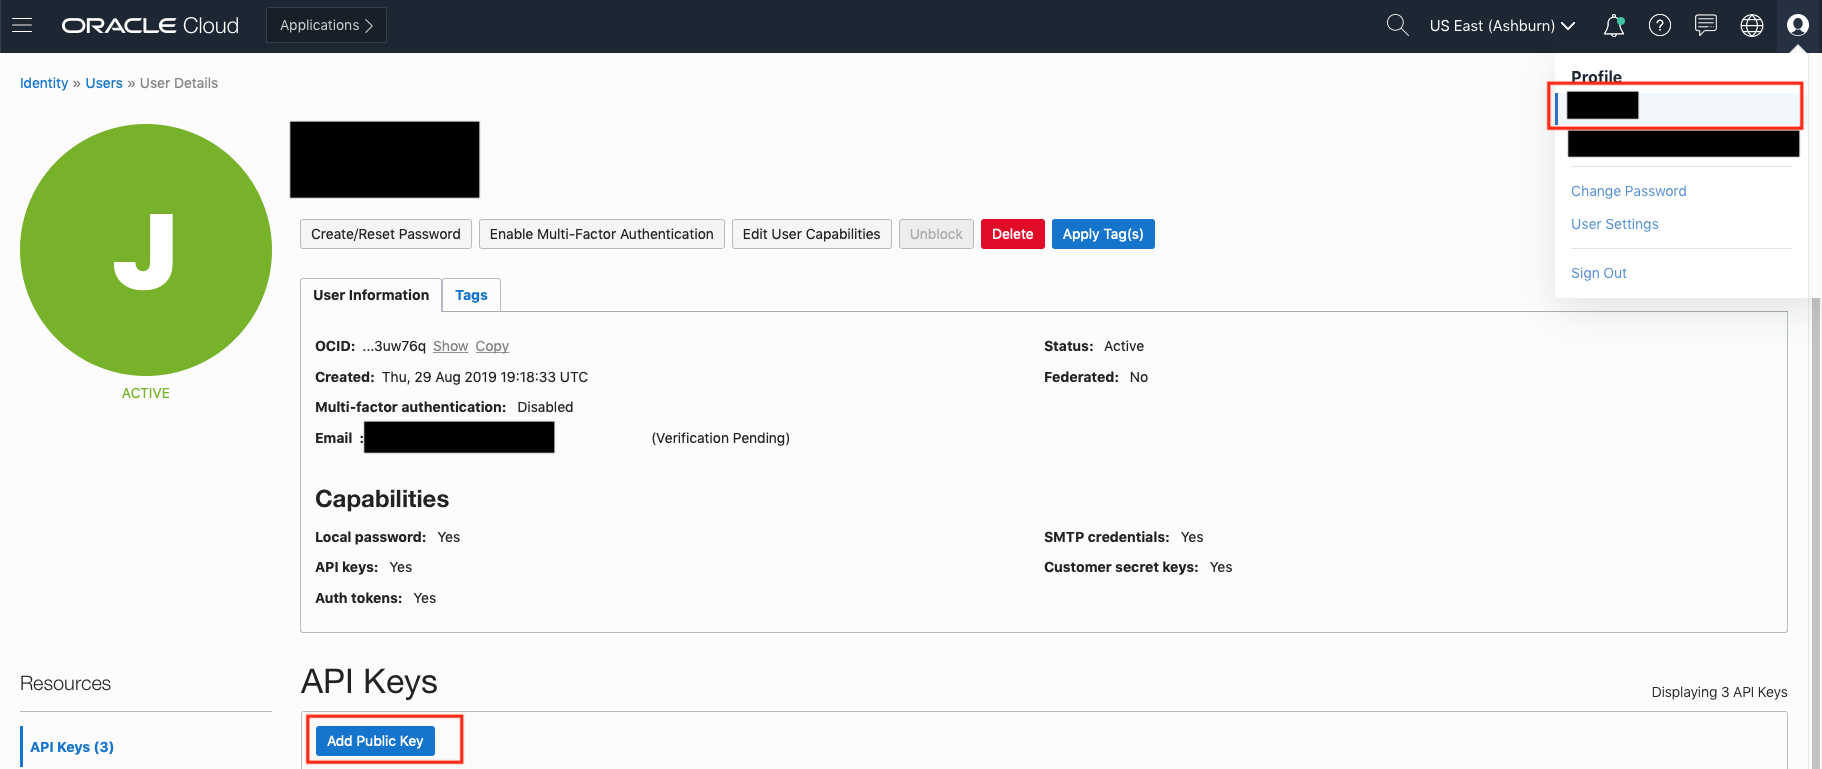

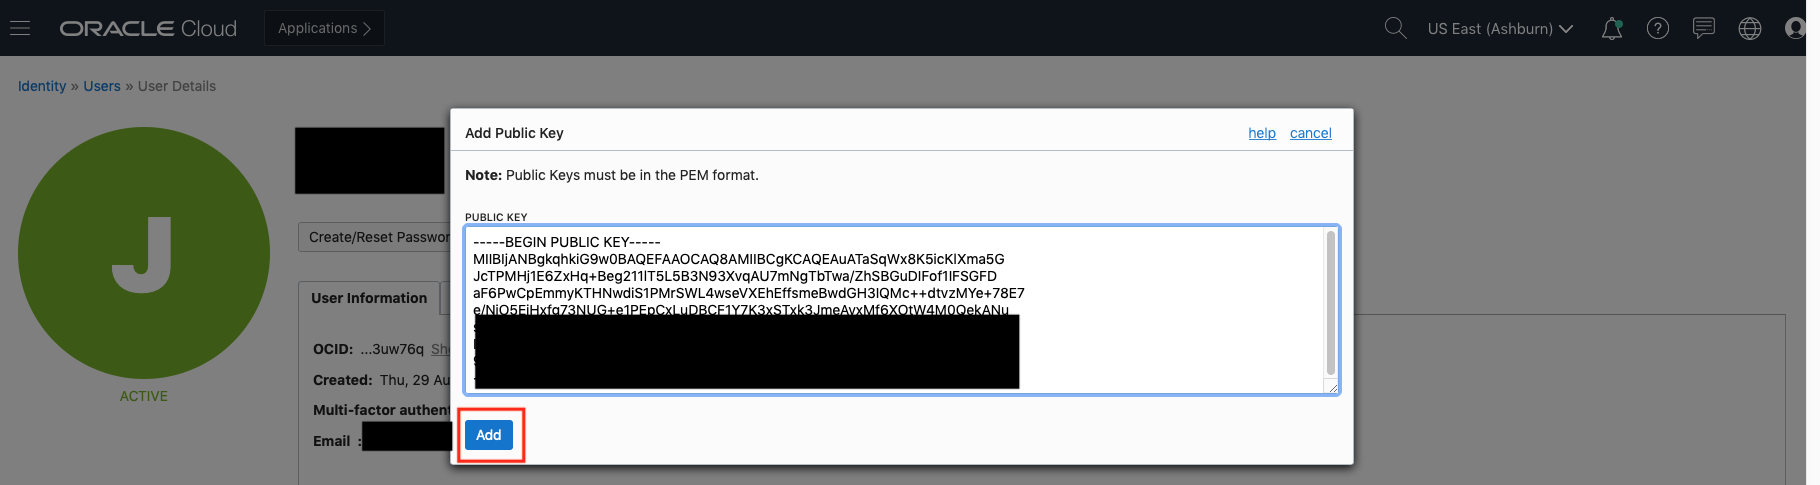

Once the public key has been attached to the user account the key's fingerprint is listed under the API Keys section. For example, `12:34:56:78:90:ab:cd:ef:12:34:56:78:90:ab:cd:ef`.

This fingerprint must match the fingerprint that is listed in the configuration file.

<a id='access-test'></a>
# Testing Access to the API

The next cell makes a call to the OCI API to attempt to get information about the project that is associated with this notebook. If the connection is successful, a message is displayed that says so. If the API call is not successful, an attempt is made to provide information about the error.

In [ ]:
client = DataScienceClient(config=from_file(config_path, "DEFAULT"))
response = None
try:
    response = client.get_project(project_id=os.environ["PROJECT_OCID"])
except ServiceError as e:
    print("Authentication with API keys is not working.")
    print("Received an unexpected response code: {}".format(e.status))
    print(e.message)

if response is not None:
    if response.status == 200:
        print("Authentication with API keys is working.")
    else:
        print("Authentication with API keys is not working.")
        print("Received an unexpected response code: {}".format(response.status))
        print(response.data)

<a href='method'></a>
# Setting Authentication Method in ADS

The Accelerated Data Science (ADS) library, is a Python library that is integrated with the Data Science service. By default, it attempts to use API keys to authenticate with OCI resources. However, the recommended method for authentication is to use resource principles.

The `set_auth()` method sets the authentication mechanism for ADS. ADS uses the `oci` SDK to access OCI resources such as, the model catalog, Object Storage, and so on. The `auth` parameter can be used to set the authentication method that is used by ADS. To explicitly use API keys, use this command:
```
ads.set_auth(auth='api_key')
```


<a href='ref'></a>
# References

- [ADS Library Documentation](https://accelerated-data-science.readthedocs.io/en/latest/index.html)
- [Data Science YouTube Videos](https://www.youtube.com/playlist?list=PLKCk3OyNwIzv6CWMhvqSB_8MLJIZdO80L)
- [How to obtain the user OCID](https://docs.cloud.oracle.com/en-us/iaas/Content/API/Concepts/apisigningkey.htm#Other)
- [How to Upload the Public Key](https://docs.cloud.oracle.com/en-us/iaas/Content/API/Concepts/apisigningkey.htm#How2)
- [OCI Data Science Documentation](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm)
- [Oracle Data & AI Blog](https://blogs.oracle.com/datascience/)
- [SDK and CLI Configuration File](https://docs.cloud.oracle.com/iaas/Content/API/Concepts/sdkconfig.htm)